<a href="https://colab.research.google.com/github/githma2000/liver-tumor-segmentation/blob/main/liver-tumor5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DATASET_PATH = '/content/drive/MyDrive/Preprocessed_3Dircadb'


In [3]:
import os
import random
import shutil

base_dir = '/content/drive/MyDrive/Preprocessed_3Dircadb'
all_patients = sorted([f for f in os.listdir(base_dir) if f.startswith('3Dircadb')])

# Shuffle and split
random.seed(42)
random.shuffle(all_patients)

train_split = int(0.7 * len(all_patients))
val_split = int(0.85 * len(all_patients))

train_patients = all_patients[:train_split]
val_patients = all_patients[train_split:val_split]
test_patients = all_patients[val_split:]

print("Train:", train_patients)
print("Val:", val_patients)
print("Test:", test_patients)


Train: ['3Dircadb1.9', '3Dircadb1.14', '3Dircadb1.4', '3Dircadb1.13', '3Dircadb1.18', '3Dircadb1.3', '3Dircadb1.5', '3Dircadb1.8', '3Dircadb1.15', '3Dircadb1.20', '3Dircadb1.7', '3Dircadb1.19', '3Dircadb1.10', '3Dircadb1.2']
Val: ['3Dircadb1.11', '3Dircadb1.6', '3Dircadb1.16']
Test: ['3Dircadb1.17', '3Dircadb1.1', '3Dircadb1.12']


In [4]:
from tensorflow.keras.utils import Sequence
import numpy as np
import os
import random

class IRCADNPYDataset(Sequence):
    def __init__(self, patient_list, base_path, batch_size=8, input_size=(256, 256),
                 shuffle=True, balance_data=True):
        self.patient_list = patient_list
        self.base_path = base_path
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.balance_data = balance_data

        self.data = self._load_all_files()
        self.on_epoch_end()

    def _load_all_files(self):
        tumor_data = []
        non_tumor_data = []

        for patient in self.patient_list:
            img_dir = os.path.join(self.base_path, patient, 'PATIENT_2_5D')
            mask_dir = os.path.join(self.base_path, patient, 'LABEL_2_5D')

            img_files = sorted(os.listdir(img_dir))
            mask_files = sorted(os.listdir(mask_dir))

            for img_file, mask_file in zip(img_files, mask_files):
                img_path = os.path.join(img_dir, img_file)
                mask_path = os.path.join(mask_dir, mask_file)

                if os.path.isfile(img_path) and os.path.isfile(mask_path):
                    mask = np.load(mask_path)
                    mask = mask.astype(np.float32)

                    # If 2D, expand to 3D for uniformity
                    if mask.ndim == 2:
                        mask = np.expand_dims(mask, axis=-1)
                    elif mask.ndim == 3 and mask.shape[2] > 1:
                        mask = mask[..., 0:1]

                    # Threshold to binarize
                    min_val = np.min(mask)
                    max_val = np.max(mask)
                    threshold = min_val + (max_val - min_val) * 0.1
                    binary_mask = (mask > threshold).astype(np.float32)

                    # Decide if this is a tumor slice
                    if np.any(binary_mask > 0):
                        tumor_data.append((img_path, mask_path))
                    else:
                        non_tumor_data.append((img_path, mask_path))

        # Balance dataset
        if self.balance_data:
            sampled_non_tumor = random.sample(non_tumor_data, min(len(tumor_data), len(non_tumor_data)))
            combined_data = tumor_data + sampled_non_tumor
        else:
            combined_data = tumor_data + non_tumor_data

        return combined_data

    def __len__(self):
        return max(1, len(self.data) // self.batch_size)

    def __getitem__(self, idx):
        batch_pairs = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, masks = [], []

        for img_path, mask_path in batch_pairs:
            img = np.load(img_path).astype(np.float32)
            mask = np.load(mask_path).astype(np.float32)

            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=-1)
            elif mask.ndim == 3 and mask.shape[2] > 1:
                mask = mask[..., 0:1]

            min_val = np.min(mask)
            max_val = np.max(mask)
            threshold = min_val + (max_val - min_val) * 0.1
            mask = (mask > threshold).astype(np.float32)

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.data)


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def ASPP(x, filters):
    """Atrous Spatial Pyramid Pooling with Keras-compatible operations"""
    shape = x.shape

    y1 = Conv2D(filters, 1, padding="same", use_bias=False)(x)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)

    y2 = Conv2D(filters, 3, padding="same", dilation_rate=6, use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filters, 3, padding="same", dilation_rate=12, use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filters, 3, padding="same", dilation_rate=18, use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    # Use GlobalAveragePooling2D and reshape for broadcast
    y5 = tf.keras.layers.GlobalAveragePooling2D()(x)
    y5 = tf.keras.layers.Reshape((1, 1, shape[-1]))(y5)
    y5 = Conv2D(filters, 1, padding="same", use_bias=False)(y5)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)
    y5 = UpSampling2D(size=(shape[1], shape[2]), interpolation="bilinear")(y5)

    y = concatenate([y1, y2, y3, y4, y5])
    y = Conv2D(filters, 1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y


def DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1):
    """Custom DeepLabV3+ model with ResNet50 backbone"""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Use features from different levels of the encoder
    image_features = base_model.get_layer("conv4_block6_2_relu").output
    x = ASPP(image_features, 256)

    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    low_level_feat = base_model.get_layer("conv2_block3_2_relu").output
    low_level_feat = Conv2D(48, 1, padding="same", use_bias=False)(low_level_feat)
    low_level_feat = BatchNormalization()(low_level_feat)
    low_level_feat = Activation("relu")(low_level_feat)

    x = concatenate([x, low_level_feat])
    x = Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    x = Conv2D(num_classes, 1, padding="same", activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model


In [6]:
import tensorflow as tf

# 1. Define loss function
def dice_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

# 2. Define metric function
def iou_metric(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1) / (union + 1)

# 3. Define and compile model
model = DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=dice_loss,
    metrics=[iou_metric]
)


In [7]:
# --- Initialize datasets ---
train_dataset = IRCADNPYDataset(
    train_patients,
    base_dir,
    batch_size=8,
    shuffle=True,
    balance_data=True  # Balance training data
)

val_dataset = IRCADNPYDataset(
    val_patients,
    base_dir,
    batch_size=8,
    shuffle=False,
    balance_data=False  # Keep validation distribution unchanged
)

test_dataset = IRCADNPYDataset(
    test_patients,
    base_dir,
    batch_size=8,
    shuffle=False,
    balance_data=False  # Same for test
)


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping: watch validation IoU
early_stop = EarlyStopping(
    monitor='val_iou_metric',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

# ModelCheckpoint: save best model based on IoU
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_deeplab_model.keras',
    monitor='val_iou_metric',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - iou_metric: 0.2455 - loss: 0.6180
Epoch 1: val_iou_metric improved from -inf to 0.10825, saving model to /content/drive/MyDrive/best_deeplab_model.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 144s 309ms/step - iou_metric: 0.2459 - loss: 0.6175 - val_iou_metric: 0.1082 - val_loss: 0.8085
Epoch 2/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - iou_metric: 0.5044 - loss: 0.3361
Epoch 2: val_iou_metric did not improve from 0.10825
233/233 ━━━━━━━━━━━━━━━━━━━━ 95s 274ms/step - iou_metric: 0.5046 - loss: 0.3359 - val_iou_metric: 0.0801 - val_loss: 0.8538
Epoch 3/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - iou_metric: 0.6228 - loss: 0.2352
Epoch 3: val_iou_metric improved from 0.10825 to 0.27538, saving model to /content/drive/MyDrive/best_deeplab_model.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 63s 270ms/step - iou_metric: 0.6229 - loss: 0.2352 - val_iou_metric: 0.2754 - val_loss: 0.5893
Epoch 4/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - iou_metric: 0.6718

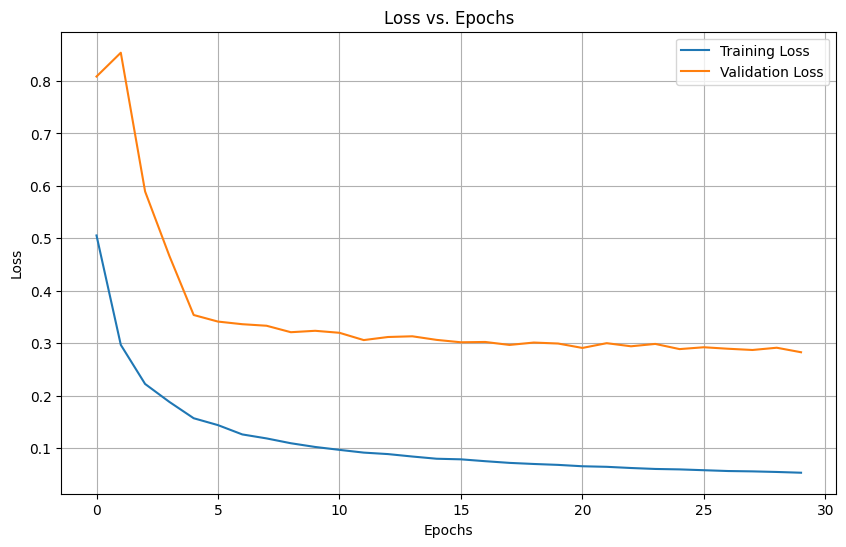

In [9]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of your model.fit() call
# Access training & validation loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


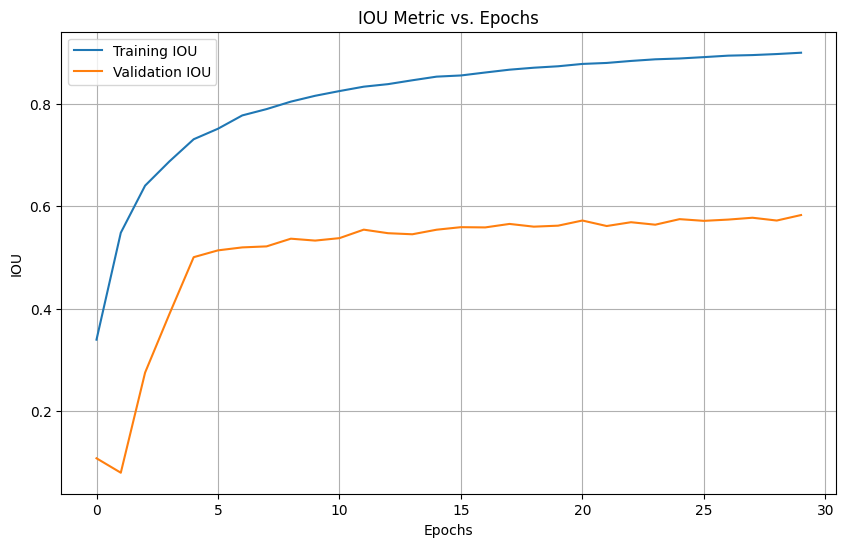

In [10]:
# Access training & validation IOU history
train_iou = history.history['iou_metric']
val_iou = history.history['val_iou_metric']

# Plotting IOU curves
plt.figure(figsize=(10, 6))
plt.plot(train_iou, label='Training IOU')
plt.plot(val_iou, label='Validation IOU')
plt.title('IOU Metric vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
from scipy.ndimage import binary_erosion

def get_surface(mask):
    eroded = binary_erosion(mask)
    surface = mask ^ eroded  # XOR: Surface pixels only
    return surface


In [13]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff
from scipy.ndimage import distance_transform_edt

def dice_coefficient(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    return (2. * intersection) / (pred.sum() + gt.sum())

def voe(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return 1 - (intersection / union)

def rvd(pred, gt):
    return (pred.sum() - gt.sum()) / gt.sum()
def assd(pred, gt):
    pred_surface = get_surface(pred)
    gt_surface = get_surface(gt)
    if np.sum(pred_surface) == 0 or np.sum(gt_surface) == 0:
        return np.nan  # Surface not found
    pred_dist = distance_transform_edt(~pred_surface)
    gt_dist = distance_transform_edt(~gt_surface)
    surface_distances = np.concatenate([
        pred_dist[gt_surface],
        gt_dist[pred_surface]
    ])
    return surface_distances.mean()

def rmsd(pred, gt):
    pred_surface = get_surface(pred)
    gt_surface = get_surface(gt)
    if np.sum(pred_surface) == 0 or np.sum(gt_surface) == 0:
        return np.nan  # Surface not found
    pred_dist = distance_transform_edt(~pred_surface)
    gt_dist = distance_transform_edt(~gt_surface)
    surface_distances = np.concatenate([
        pred_dist[gt_surface],
        gt_dist[pred_surface]
    ])
    return np.sqrt((surface_distances ** 2).mean())


# Example usage
# pred_mask and gt_mask should be binary (0 and 1) masks

# Example dummy masks (replace with your real predictions)
pred_mask = np.random.randint(0, 2, (256, 256))
gt_mask = np.random.randint(0, 2, (256, 256))

dice = dice_coefficient(pred_mask, gt_mask)
voe_score = voe(pred_mask, gt_mask)
rvd_score = rvd(pred_mask, gt_mask)
assd_score = assd(pred_mask, gt_mask)
rmsd_score = rmsd(pred_mask, gt_mask)

print(f"Dice Coefficient: {dice:.4f}")
print(f"VOE: {voe_score:.4f}")
print(f"RVD: {rvd_score:.4f}")
print(f"ASSD: {assd_score:.4f}")
print(f"RMSD: {rmsd_score:.4f}")


Dice Coefficient: 0.5029
VOE: 0.6641
RVD: 0.0009
ASSD: 127.5323
RMSD: 147.3767


In [14]:
import matplotlib.pyplot as plt

def show_sample(image, gt_mask, pred_mask):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image[..., 0], cmap='gray')
    plt.title('Input Image')
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask[..., 0], cmap='gray')
    plt.title('Ground Truth')
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask[..., 0], cmap='gray')
    plt.title('Prediction')
    plt.show()
